In [9]:
import torch
from tqdm import tqdm
from torch import nn, optim
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude", 
                                                        "SL_charbakh_subway", "SL_avan", "SL_massiv"])

In [10]:
# # Selecting numerical columns for outlier analysis
# col = 'price'

# # Outlier analysis using IQR
# outlier_info = {}

# Q1 = data[col].quantile(0.25)
# Q3 = data[col].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Counting outliers
# outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
# print(outliers)

In [1]:
base_neuron_count = 32

class ResidualBlock(nn.Module):
    def __init__(self, n_features):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(n_features, n_features)
        self.activation = nn.ELU()

    def forward(self, x):
        return self.activation(self.fc(x) + x)

class TabularFFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularFFNN, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count),
            nn.ELU(),
            nn.LayerNorm(base_neuron_count),
            nn.Linear(base_neuron_count, base_neuron_count * 2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(base_neuron_count * 2, base_neuron_count * 2),
            nn.ELU(),
            nn.LayerNorm(base_neuron_count * 2),
            nn.Linear(base_neuron_count * 2, base_neuron_count // 2),
            ResidualBlock(base_neuron_count // 2),
            nn.Dropout(0.4),
            nn.Linear(base_neuron_count // 2, output_size)
        )

    def forward(self, x):
        x = x.float()
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
class TabularFFNNOLD(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNOLD, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count), 
            nn.BatchNorm1d(base_neuron_count),  # Ensure the input here has 512 features
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count), # 16
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(base_neuron_count, output_size)
        )

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, output_size)
        )

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNOLD(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 3000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it

optimizer = optim.Adam(
    model.parameters(), 
    lr=8e-4,
    weight_decay=5e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=10, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    for tuple_ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    
    print(f'Epoch {epoch+1}, Training Loss: {int(train_losses[-1])}, Validation Loss: {int(val_losses[-1])}, L1: {int(l1_mean_loss)}')

NameError: name 'nn' is not defined

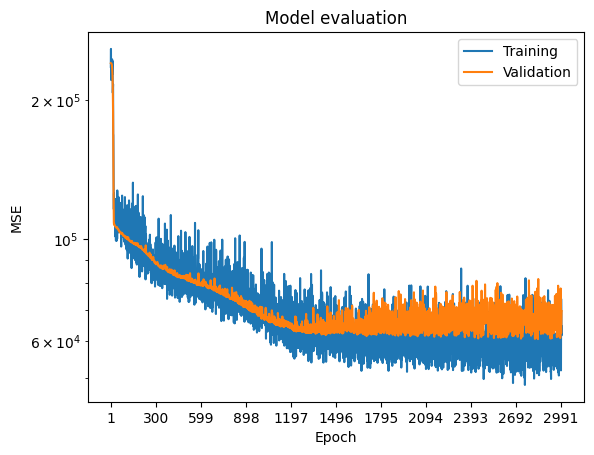

In [17]:
import matplotlib.pyplot as plt
plt.title("Model evaluation")
plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(range(1, epochs_suc[-1], int(epochs_suc[-1] / 10)))
plt.legend()

In [100]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_layer_size,
                 hidden_layer_count,
                 output_size = 1):
        
        super(TabularFFNNSimple, self).__init__()
        
        layers = [nn.Linear(input_size, hidden_layer_size), nn.ReLU()]
        
        for _ in range(hidden_layer_count - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.LeakyReLU())
            
        layers.append(nn.Linear(hidden_layer_size, output_size))
        
        self.ffnn = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x

def train(batch_size, hidden_layer_size, hidden_layer_count):

    # Split the data into features and target
    X = data.drop('price', axis=1)
    y = data['price']

    # Standardize the features
    device = torch.device("cpu")
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
    y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


    # Split the data into training and combined validation and testing sets
    X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                                test_size=0.4, random_state=42)

    # Split the combined validation and testing sets
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    # Create DataLoader for training, validation, and testing
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Check if the dimensions match the expected input size for the model
    input_size = X_train.shape[1]

    # Output
    # input_size, train_loader, test_loader

    model = TabularFFNNSimple(
        input_size = input_size,
        hidden_layer_size = hidden_layer_size,
        hidden_layer_count = hidden_layer_count,
        output_size = 1
    )
    model.to(device)

    num_epochs = 3000
    train_losses = []
    val_losses = []
    epochs_suc = [] # to have a reference to it

    optimizer = optim.Adam(
        model.parameters(), 
        lr=8e-4,
        weight_decay=5e-4
    )
    criterion = torch.nn.MSELoss()
    criterion_abs = torch.nn.L1Loss()
    criterion = criterion_abs

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.999999, 
        patience=10, 
        verbose=True
    )

    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        running_loss = 0.0
        l1_losses = []
        for tuple_ in train_loader:
            datas, prices = tuple_
            optimizer.zero_grad()
            outputs = model(datas)
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for tuple_ in val_loader:
                datas, prices = tuple_
                outputs = model(datas)  # Forward pass
                prices_viewed = prices.view(-1, 1).float()
                loss = criterion(outputs, prices_viewed)  # Compute loss
                val_loss += loss.item()  # Accumulate the loss
                l1_losses.append(criterion_abs(outputs, prices_viewed))

        val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
        l1_mean_loss = sum(l1_losses) / len(l1_losses)

        epochs_suc.append(epoch)
        scheduler.step(val_losses[-1])
        print(f'Epoch {epoch+1}, \
                Training Loss: {int(train_losses[-1])}, \
                Validation Loss: {int(val_losses[-1])}, L1: {int(l1_mean_loss)}')

    
    return train_losses, val_losses

In [102]:
train(64, 32, 16)

Epoch 1,                 Training Loss: 239507,                 Validation Loss: 237475, L1: 237475
Epoch 2,                 Training Loss: 237331,                 Validation Loss: 237382, L1: 237382
Epoch 3,                 Training Loss: 233229,                 Validation Loss: 192281, L1: 192281
Epoch 4,                 Training Loss: 127584,                 Validation Loss: 106469, L1: 106469
Epoch 5,                 Training Loss: 110154,                 Validation Loss: 105067, L1: 105067
Epoch 6,                 Training Loss: 109123,                 Validation Loss: 103399, L1: 103399
Epoch 7,                 Training Loss: 106121,                 Validation Loss: 102451, L1: 102451
Epoch 8,                 Training Loss: 101774,                 Validation Loss: 104162, L1: 104162
Epoch 9,                 Training Loss: 102749,                 Validation Loss: 101047, L1: 101047
Epoch 10,                 Training Loss: 103312,                 Validation Loss: 98774, L1: 98774
E

Epoch 93,                 Training Loss: 59883,                 Validation Loss: 62253, L1: 62253
Epoch 94,                 Training Loss: 56888,                 Validation Loss: 62144, L1: 62144
Epoch 95,                 Training Loss: 54079,                 Validation Loss: 78556, L1: 78556
Epoch 96,                 Training Loss: 63248,                 Validation Loss: 64779, L1: 64779
Epoch 97,                 Training Loss: 59359,                 Validation Loss: 89970, L1: 89970
Epoch 98,                 Training Loss: 61633,                 Validation Loss: 61672, L1: 61672
Epoch 99,                 Training Loss: 57105,                 Validation Loss: 62498, L1: 62498
Epoch 100,                 Training Loss: 57593,                 Validation Loss: 63846, L1: 63846
Epoch 101,                 Training Loss: 55825,                 Validation Loss: 68871, L1: 68871
Epoch 102,                 Training Loss: 61858,                 Validation Loss: 61427, L1: 61427
Epoch 103,       

Epoch 178,                 Training Loss: 55816,                 Validation Loss: 64174, L1: 64174
Epoch 179,                 Training Loss: 58312,                 Validation Loss: 61035, L1: 61035
Epoch 180,                 Training Loss: 55632,                 Validation Loss: 59903, L1: 59903
Epoch 181,                 Training Loss: 55059,                 Validation Loss: 59512, L1: 59512
Epoch 182,                 Training Loss: 54423,                 Validation Loss: 64843, L1: 64843
Epoch 183,                 Training Loss: 64238,                 Validation Loss: 59407, L1: 59407
Epoch 184,                 Training Loss: 57999,                 Validation Loss: 60688, L1: 60688
Epoch 185,                 Training Loss: 53536,                 Validation Loss: 61435, L1: 61435
Epoch 186,                 Training Loss: 54313,                 Validation Loss: 58983, L1: 58983
Epoch 187,                 Training Loss: 52719,                 Validation Loss: 59119, L1: 59119
Epoch 188,

Epoch 265,                 Training Loss: 53690,                 Validation Loss: 61315, L1: 61315
Epoch 266,                 Training Loss: 53559,                 Validation Loss: 58096, L1: 58096
Epoch 267,                 Training Loss: 52621,                 Validation Loss: 59328, L1: 59328
Epoch 268,                 Training Loss: 55729,                 Validation Loss: 57657, L1: 57657
Epoch 269,                 Training Loss: 50633,                 Validation Loss: 63692, L1: 63692
Epoch 270,                 Training Loss: 60155,                 Validation Loss: 66159, L1: 66159
Epoch 271,                 Training Loss: 53585,                 Validation Loss: 58209, L1: 58209
Epoch 272,                 Training Loss: 51295,                 Validation Loss: 58944, L1: 58944
Epoch 273,                 Training Loss: 51746,                 Validation Loss: 58443, L1: 58443
Epoch 274,                 Training Loss: 53715,                 Validation Loss: 60206, L1: 60206
Epoch 275,

Epoch 354,                 Training Loss: 52609,                 Validation Loss: 57477, L1: 57477
Epoch 355,                 Training Loss: 49839,                 Validation Loss: 56395, L1: 56395
Epoch 356,                 Training Loss: 49303,                 Validation Loss: 56782, L1: 56782
Epoch 357,                 Training Loss: 52227,                 Validation Loss: 56810, L1: 56810
Epoch 358,                 Training Loss: 51187,                 Validation Loss: 57256, L1: 57256
Epoch 359,                 Training Loss: 50267,                 Validation Loss: 58261, L1: 58261
Epoch 360,                 Training Loss: 52110,                 Validation Loss: 64872, L1: 64872
Epoch 361,                 Training Loss: 54689,                 Validation Loss: 65492, L1: 65492
Epoch 362,                 Training Loss: 55104,                 Validation Loss: 57786, L1: 57786
Epoch 363,                 Training Loss: 52575,                 Validation Loss: 56548, L1: 56548
Epoch 364,

Epoch 442,                 Training Loss: 46134,                 Validation Loss: 56398, L1: 56398
Epoch 443,                 Training Loss: 49101,                 Validation Loss: 55871, L1: 55871
Epoch 444,                 Training Loss: 48083,                 Validation Loss: 58058, L1: 58058
Epoch 445,                 Training Loss: 49629,                 Validation Loss: 55757, L1: 55757
Epoch 446,                 Training Loss: 49737,                 Validation Loss: 55376, L1: 55376
Epoch 447,                 Training Loss: 46708,                 Validation Loss: 56668, L1: 56668
Epoch 448,                 Training Loss: 47623,                 Validation Loss: 55360, L1: 55360
Epoch 449,                 Training Loss: 49316,                 Validation Loss: 57433, L1: 57433
Epoch 450,                 Training Loss: 48414,                 Validation Loss: 60087, L1: 60087
Epoch 451,                 Training Loss: 48904,                 Validation Loss: 55807, L1: 55807
Epoch 452,

Epoch 528,                 Training Loss: 49105,                 Validation Loss: 54011, L1: 54011
Epoch 529,                 Training Loss: 47717,                 Validation Loss: 65190, L1: 65190
Epoch 530,                 Training Loss: 55459,                 Validation Loss: 55541, L1: 55541
Epoch 531,                 Training Loss: 49083,                 Validation Loss: 54688, L1: 54688
Epoch 532,                 Training Loss: 45346,                 Validation Loss: 56633, L1: 56633
Epoch 533,                 Training Loss: 45986,                 Validation Loss: 56586, L1: 56586
Epoch 534,                 Training Loss: 47570,                 Validation Loss: 53783, L1: 53783
Epoch 535,                 Training Loss: 47125,                 Validation Loss: 54313, L1: 54313
Epoch 536,                 Training Loss: 50700,                 Validation Loss: 53977, L1: 53977
Epoch 537,                 Training Loss: 46267,                 Validation Loss: 54373, L1: 54373
Epoch 538,

Epoch 615,                 Training Loss: 45549,                 Validation Loss: 56912, L1: 56912
Epoch 616,                 Training Loss: 46605,                 Validation Loss: 55611, L1: 55611
Epoch 617,                 Training Loss: 47643,                 Validation Loss: 53900, L1: 53900
Epoch 618,                 Training Loss: 46401,                 Validation Loss: 55559, L1: 55559
Epoch 619,                 Training Loss: 46909,                 Validation Loss: 57838, L1: 57838
Epoch 620,                 Training Loss: 47145,                 Validation Loss: 53348, L1: 53348
Epoch 621,                 Training Loss: 46309,                 Validation Loss: 53322, L1: 53322
Epoch 622,                 Training Loss: 47960,                 Validation Loss: 62228, L1: 62228
Epoch 623,                 Training Loss: 48271,                 Validation Loss: 56435, L1: 56435
Epoch 624,                 Training Loss: 46237,                 Validation Loss: 53732, L1: 53732
Epoch 625,

Epoch 701,                 Training Loss: 46696,                 Validation Loss: 52822, L1: 52822
Epoch 702,                 Training Loss: 49218,                 Validation Loss: 59881, L1: 59881
Epoch 703,                 Training Loss: 50781,                 Validation Loss: 52702, L1: 52702
Epoch 704,                 Training Loss: 44492,                 Validation Loss: 52483, L1: 52483
Epoch 705,                 Training Loss: 46312,                 Validation Loss: 54647, L1: 54647
Epoch 706,                 Training Loss: 45876,                 Validation Loss: 53875, L1: 53875
Epoch 707,                 Training Loss: 44377,                 Validation Loss: 53233, L1: 53233
Epoch 708,                 Training Loss: 45264,                 Validation Loss: 53277, L1: 53277
Epoch 709,                 Training Loss: 45826,                 Validation Loss: 52206, L1: 52206
Epoch 710,                 Training Loss: 43522,                 Validation Loss: 56673, L1: 56673
Epoch 711,

Epoch 786,                 Training Loss: 46176,                 Validation Loss: 63099, L1: 63099
Epoch 787,                 Training Loss: 54015,                 Validation Loss: 58623, L1: 58623
Epoch 788,                 Training Loss: 47349,                 Validation Loss: 58301, L1: 58301
Epoch 789,                 Training Loss: 47871,                 Validation Loss: 51808, L1: 51808
Epoch 790,                 Training Loss: 48756,                 Validation Loss: 52269, L1: 52269
Epoch 791,                 Training Loss: 46200,                 Validation Loss: 52759, L1: 52759
Epoch 792,                 Training Loss: 46388,                 Validation Loss: 56667, L1: 56667
Epoch 793,                 Training Loss: 53408,                 Validation Loss: 51678, L1: 51678
Epoch 794,                 Training Loss: 44857,                 Validation Loss: 51866, L1: 51866
Epoch 795,                 Training Loss: 43205,                 Validation Loss: 51407, L1: 51407
Epoch 796,

Epoch 872,                 Training Loss: 42974,                 Validation Loss: 51788, L1: 51788
Epoch 873,                 Training Loss: 43314,                 Validation Loss: 51386, L1: 51386
Epoch 874,                 Training Loss: 43780,                 Validation Loss: 53179, L1: 53179
Epoch 875,                 Training Loss: 43120,                 Validation Loss: 59202, L1: 59202
Epoch 876,                 Training Loss: 49797,                 Validation Loss: 52263, L1: 52263
Epoch 877,                 Training Loss: 46997,                 Validation Loss: 50884, L1: 50884
Epoch 878,                 Training Loss: 41651,                 Validation Loss: 51375, L1: 51375
Epoch 879,                 Training Loss: 42854,                 Validation Loss: 50457, L1: 50457
Epoch 880,                 Training Loss: 41180,                 Validation Loss: 50929, L1: 50929
Epoch 881,                 Training Loss: 42052,                 Validation Loss: 52974, L1: 52974
Epoch 882,

Epoch 961,                 Training Loss: 42999,                 Validation Loss: 51590, L1: 51590
Epoch 962,                 Training Loss: 44005,                 Validation Loss: 50651, L1: 50651
Epoch 963,                 Training Loss: 47684,                 Validation Loss: 51585, L1: 51585
Epoch 964,                 Training Loss: 43990,                 Validation Loss: 50790, L1: 50790
Epoch 965,                 Training Loss: 44178,                 Validation Loss: 50243, L1: 50243
Epoch 966,                 Training Loss: 42590,                 Validation Loss: 50995, L1: 50995
Epoch 967,                 Training Loss: 41484,                 Validation Loss: 49858, L1: 49858
Epoch 968,                 Training Loss: 40505,                 Validation Loss: 52053, L1: 52053
Epoch 969,                 Training Loss: 44286,                 Validation Loss: 57485, L1: 57485
Epoch 970,                 Training Loss: 45590,                 Validation Loss: 53015, L1: 53015
Epoch 971,

Epoch 1048,                 Training Loss: 46046,                 Validation Loss: 51144, L1: 51144
Epoch 1049,                 Training Loss: 45031,                 Validation Loss: 50224, L1: 50224
Epoch 1050,                 Training Loss: 45332,                 Validation Loss: 50506, L1: 50506
Epoch 1051,                 Training Loss: 43271,                 Validation Loss: 51589, L1: 51589
Epoch 1052,                 Training Loss: 41298,                 Validation Loss: 50941, L1: 50941
Epoch 1053,                 Training Loss: 42251,                 Validation Loss: 53193, L1: 53193
Epoch 1054,                 Training Loss: 44200,                 Validation Loss: 56305, L1: 56305
Epoch 1055,                 Training Loss: 50610,                 Validation Loss: 50546, L1: 50546
Epoch 1056,                 Training Loss: 42402,                 Validation Loss: 50709, L1: 50709
Epoch 1057,                 Training Loss: 40769,                 Validation Loss: 50854, L1: 50854


Epoch 1134,                 Training Loss: 45430,                 Validation Loss: 50598, L1: 50598
Epoch 1135,                 Training Loss: 41825,                 Validation Loss: 49809, L1: 49809
Epoch 1136,                 Training Loss: 42783,                 Validation Loss: 52778, L1: 52778
Epoch 1137,                 Training Loss: 45196,                 Validation Loss: 50565, L1: 50565
Epoch 1138,                 Training Loss: 42597,                 Validation Loss: 51183, L1: 51183
Epoch 1139,                 Training Loss: 40971,                 Validation Loss: 50336, L1: 50336
Epoch 1140,                 Training Loss: 41414,                 Validation Loss: 50000, L1: 50000
Epoch 1141,                 Training Loss: 40944,                 Validation Loss: 49553, L1: 49552
Epoch 1142,                 Training Loss: 44230,                 Validation Loss: 50951, L1: 50951
Epoch 1143,                 Training Loss: 41705,                 Validation Loss: 53866, L1: 53866


Epoch 1221,                 Training Loss: 43616,                 Validation Loss: 66995, L1: 66995
Epoch 1222,                 Training Loss: 50627,                 Validation Loss: 51371, L1: 51371
Epoch 1223,                 Training Loss: 44205,                 Validation Loss: 49651, L1: 49651
Epoch 1224,                 Training Loss: 41429,                 Validation Loss: 49498, L1: 49498
Epoch 1225,                 Training Loss: 45114,                 Validation Loss: 50294, L1: 50294
Epoch 1226,                 Training Loss: 42469,                 Validation Loss: 52021, L1: 52021
Epoch 1227,                 Training Loss: 45782,                 Validation Loss: 61085, L1: 61085
Epoch 1228,                 Training Loss: 49758,                 Validation Loss: 56393, L1: 56393
Epoch 1229,                 Training Loss: 47656,                 Validation Loss: 50326, L1: 50326
Epoch 1230,                 Training Loss: 42822,                 Validation Loss: 50457, L1: 50457


Epoch 1303,                 Training Loss: 46766,                 Validation Loss: 60465, L1: 60465
Epoch 1304,                 Training Loss: 45706,                 Validation Loss: 49650, L1: 49650
Epoch 1305,                 Training Loss: 45351,                 Validation Loss: 52534, L1: 52534
Epoch 1306,                 Training Loss: 46172,                 Validation Loss: 51227, L1: 51227
Epoch 1307,                 Training Loss: 43976,                 Validation Loss: 49121, L1: 49121
Epoch 1308,                 Training Loss: 40055,                 Validation Loss: 49165, L1: 49165
Epoch 1309,                 Training Loss: 42877,                 Validation Loss: 50962, L1: 50962
Epoch 1310,                 Training Loss: 44113,                 Validation Loss: 49712, L1: 49712
Epoch 1311,                 Training Loss: 40755,                 Validation Loss: 49368, L1: 49368
Epoch 1312,                 Training Loss: 42048,                 Validation Loss: 51060, L1: 51060


Epoch 1389,                 Training Loss: 40287,                 Validation Loss: 52246, L1: 52246
Epoch 1390,                 Training Loss: 46825,                 Validation Loss: 48877, L1: 48877
Epoch 1391,                 Training Loss: 41206,                 Validation Loss: 49412, L1: 49412
Epoch 1392,                 Training Loss: 44039,                 Validation Loss: 52594, L1: 52594
Epoch 1393,                 Training Loss: 45458,                 Validation Loss: 49131, L1: 49131
Epoch 1394,                 Training Loss: 38585,                 Validation Loss: 54267, L1: 54267
Epoch 1395,                 Training Loss: 42088,                 Validation Loss: 51088, L1: 51088
Epoch 1396,                 Training Loss: 41560,                 Validation Loss: 49953, L1: 49953
Epoch 1397,                 Training Loss: 42704,                 Validation Loss: 51589, L1: 51589
Epoch 1398,                 Training Loss: 40818,                 Validation Loss: 50021, L1: 50021


Epoch 1478,                 Training Loss: 43910,                 Validation Loss: 54518, L1: 54518
Epoch 1479,                 Training Loss: 42398,                 Validation Loss: 52330, L1: 52330
Epoch 1480,                 Training Loss: 40946,                 Validation Loss: 51213, L1: 51213
Epoch 1481,                 Training Loss: 43088,                 Validation Loss: 52155, L1: 52155
Epoch 1482,                 Training Loss: 39577,                 Validation Loss: 49093, L1: 49093
Epoch 1483,                 Training Loss: 42353,                 Validation Loss: 52190, L1: 52190
Epoch 1484,                 Training Loss: 40854,                 Validation Loss: 50217, L1: 50217
Epoch 1485,                 Training Loss: 44175,                 Validation Loss: 50062, L1: 50062
Epoch 1486,                 Training Loss: 42207,                 Validation Loss: 48466, L1: 48466
Epoch 1487,                 Training Loss: 40035,                 Validation Loss: 49170, L1: 49170


Epoch 1568,                 Training Loss: 38390,                 Validation Loss: 48946, L1: 48946
Epoch 1569,                 Training Loss: 40638,                 Validation Loss: 48165, L1: 48165
Epoch 1570,                 Training Loss: 41265,                 Validation Loss: 47794, L1: 47794
Epoch 1571,                 Training Loss: 39929,                 Validation Loss: 49831, L1: 49831
Epoch 1572,                 Training Loss: 40068,                 Validation Loss: 48054, L1: 48054
Epoch 1573,                 Training Loss: 37970,                 Validation Loss: 48248, L1: 48248
Epoch 1574,                 Training Loss: 41272,                 Validation Loss: 48034, L1: 48034
Epoch 1575,                 Training Loss: 39908,                 Validation Loss: 52429, L1: 52429
Epoch 1576,                 Training Loss: 40862,                 Validation Loss: 53418, L1: 53418
Epoch 1577,                 Training Loss: 41858,                 Validation Loss: 48441, L1: 48441


Epoch 1656,                 Training Loss: 38548,                 Validation Loss: 48763, L1: 48763
Epoch 1657,                 Training Loss: 39998,                 Validation Loss: 49256, L1: 49256
Epoch 1658,                 Training Loss: 42044,                 Validation Loss: 60512, L1: 60512
Epoch 1659,                 Training Loss: 49578,                 Validation Loss: 48858, L1: 48858
Epoch 1660,                 Training Loss: 42862,                 Validation Loss: 48355, L1: 48355
Epoch 1661,                 Training Loss: 42076,                 Validation Loss: 48366, L1: 48366
Epoch 1662,                 Training Loss: 41268,                 Validation Loss: 53657, L1: 53657
Epoch 1663,                 Training Loss: 40690,                 Validation Loss: 49063, L1: 49063
Epoch 1664,                 Training Loss: 40954,                 Validation Loss: 50694, L1: 50694
Epoch 1665,                 Training Loss: 38649,                 Validation Loss: 47899, L1: 47899


Epoch 1744,                 Training Loss: 38803,                 Validation Loss: 58195, L1: 58195
Epoch 1745,                 Training Loss: 40949,                 Validation Loss: 56686, L1: 56686
Epoch 1746,                 Training Loss: 45470,                 Validation Loss: 49025, L1: 49025
Epoch 1747,                 Training Loss: 37906,                 Validation Loss: 47623, L1: 47623
Epoch 1748,                 Training Loss: 42232,                 Validation Loss: 48970, L1: 48970
Epoch 1749,                 Training Loss: 41966,                 Validation Loss: 48504, L1: 48504
Epoch 1750,                 Training Loss: 37417,                 Validation Loss: 48527, L1: 48527
Epoch 1751,                 Training Loss: 38001,                 Validation Loss: 59077, L1: 59077
Epoch 1752,                 Training Loss: 45009,                 Validation Loss: 49578, L1: 49578
Epoch 1753,                 Training Loss: 40120,                 Validation Loss: 49295, L1: 49295


Epoch 1829,                 Training Loss: 39152,                 Validation Loss: 50410, L1: 50410
Epoch 1830,                 Training Loss: 40583,                 Validation Loss: 49540, L1: 49540
Epoch 1831,                 Training Loss: 40463,                 Validation Loss: 49072, L1: 49072
Epoch 1832,                 Training Loss: 41780,                 Validation Loss: 51658, L1: 51658
Epoch 1833,                 Training Loss: 41399,                 Validation Loss: 66610, L1: 66610
Epoch 1834,                 Training Loss: 48645,                 Validation Loss: 50198, L1: 50198
Epoch 1835,                 Training Loss: 39245,                 Validation Loss: 48194, L1: 48194
Epoch 1836,                 Training Loss: 43550,                 Validation Loss: 50253, L1: 50253
Epoch 1837,                 Training Loss: 43215,                 Validation Loss: 49002, L1: 49002
Epoch 1838,                 Training Loss: 38281,                 Validation Loss: 50802, L1: 50802


Epoch 1911,                 Training Loss: 40276,                 Validation Loss: 47977, L1: 47977
Epoch 1912,                 Training Loss: 40319,                 Validation Loss: 52415, L1: 52415
Epoch 1913,                 Training Loss: 39666,                 Validation Loss: 47896, L1: 47896
Epoch 1914,                 Training Loss: 38589,                 Validation Loss: 48674, L1: 48674
Epoch 1915,                 Training Loss: 39092,                 Validation Loss: 51938, L1: 51938
Epoch 1916,                 Training Loss: 37114,                 Validation Loss: 47991, L1: 47991
Epoch 1917,                 Training Loss: 38228,                 Validation Loss: 48909, L1: 48909
Epoch 1918,                 Training Loss: 37773,                 Validation Loss: 53130, L1: 53130
Epoch 1919,                 Training Loss: 41347,                 Validation Loss: 52036, L1: 52036
Epoch 1920,                 Training Loss: 39535,                 Validation Loss: 47990, L1: 47990


Epoch 1999,                 Training Loss: 41774,                 Validation Loss: 51322, L1: 51322
Epoch 2000,                 Training Loss: 44192,                 Validation Loss: 49641, L1: 49641
Epoch 2001,                 Training Loss: 41311,                 Validation Loss: 49057, L1: 49057
Epoch 2002,                 Training Loss: 44615,                 Validation Loss: 49062, L1: 49062
Epoch 2003,                 Training Loss: 39098,                 Validation Loss: 55154, L1: 55154
Epoch 2004,                 Training Loss: 42386,                 Validation Loss: 50697, L1: 50697
Epoch 2005,                 Training Loss: 40776,                 Validation Loss: 49642, L1: 49642
Epoch 2006,                 Training Loss: 37217,                 Validation Loss: 50940, L1: 50940
Epoch 2007,                 Training Loss: 40345,                 Validation Loss: 47463, L1: 47463
Epoch 2008,                 Training Loss: 39276,                 Validation Loss: 50080, L1: 50080


Epoch 2084,                 Training Loss: 44531,                 Validation Loss: 49602, L1: 49602
Epoch 2085,                 Training Loss: 35959,                 Validation Loss: 48426, L1: 48426
Epoch 2086,                 Training Loss: 40530,                 Validation Loss: 49221, L1: 49221
Epoch 2087,                 Training Loss: 40524,                 Validation Loss: 51346, L1: 51346
Epoch 2088,                 Training Loss: 38388,                 Validation Loss: 48585, L1: 48585
Epoch 2089,                 Training Loss: 36536,                 Validation Loss: 49639, L1: 49639
Epoch 2090,                 Training Loss: 38304,                 Validation Loss: 47951, L1: 47951
Epoch 2091,                 Training Loss: 37075,                 Validation Loss: 48429, L1: 48429
Epoch 2092,                 Training Loss: 41253,                 Validation Loss: 48564, L1: 48564
Epoch 2093,                 Training Loss: 38844,                 Validation Loss: 49826, L1: 49826


Epoch 2173,                 Training Loss: 35361,                 Validation Loss: 48124, L1: 48124
Epoch 2174,                 Training Loss: 36145,                 Validation Loss: 47639, L1: 47639
Epoch 2175,                 Training Loss: 38300,                 Validation Loss: 54294, L1: 54294
Epoch 2176,                 Training Loss: 43170,                 Validation Loss: 48330, L1: 48330
Epoch 2177,                 Training Loss: 37519,                 Validation Loss: 49073, L1: 49073
Epoch 2178,                 Training Loss: 38755,                 Validation Loss: 49049, L1: 49049
Epoch 2179,                 Training Loss: 37031,                 Validation Loss: 51356, L1: 51356
Epoch 2180,                 Training Loss: 35991,                 Validation Loss: 48461, L1: 48461
Epoch 2181,                 Training Loss: 36829,                 Validation Loss: 48005, L1: 48005
Epoch 2182,                 Training Loss: 35805,                 Validation Loss: 48791, L1: 48791


Epoch 2262,                 Training Loss: 42981,                 Validation Loss: 53211, L1: 53211
Epoch 2263,                 Training Loss: 39607,                 Validation Loss: 51340, L1: 51340
Epoch 2264,                 Training Loss: 39060,                 Validation Loss: 49026, L1: 49026
Epoch 2265,                 Training Loss: 38176,                 Validation Loss: 50144, L1: 50144
Epoch 2266,                 Training Loss: 38628,                 Validation Loss: 50437, L1: 50437
Epoch 2267,                 Training Loss: 39043,                 Validation Loss: 53362, L1: 53362
Epoch 2268,                 Training Loss: 39952,                 Validation Loss: 47435, L1: 47435
Epoch 2269,                 Training Loss: 38163,                 Validation Loss: 47729, L1: 47729
Epoch 2270,                 Training Loss: 35671,                 Validation Loss: 48205, L1: 48205
Epoch 2271,                 Training Loss: 36596,                 Validation Loss: 48784, L1: 48784


Epoch 2352,                 Training Loss: 38665,                 Validation Loss: 48160, L1: 48160
Epoch 2353,                 Training Loss: 37111,                 Validation Loss: 51279, L1: 51279
Epoch 2354,                 Training Loss: 38525,                 Validation Loss: 51383, L1: 51383
Epoch 2355,                 Training Loss: 36655,                 Validation Loss: 47947, L1: 47947
Epoch 2356,                 Training Loss: 40924,                 Validation Loss: 48941, L1: 48941
Epoch 2357,                 Training Loss: 36249,                 Validation Loss: 48185, L1: 48185
Epoch 2358,                 Training Loss: 35502,                 Validation Loss: 48403, L1: 48403
Epoch 2359,                 Training Loss: 35592,                 Validation Loss: 48366, L1: 48366
Epoch 2360,                 Training Loss: 36555,                 Validation Loss: 50359, L1: 50359
Epoch 2361,                 Training Loss: 38187,                 Validation Loss: 49785, L1: 49785


Epoch 2442,                 Training Loss: 35199,                 Validation Loss: 48687, L1: 48687
Epoch 2443,                 Training Loss: 36108,                 Validation Loss: 49333, L1: 49333
Epoch 2444,                 Training Loss: 35973,                 Validation Loss: 49315, L1: 49315
Epoch 2445,                 Training Loss: 36244,                 Validation Loss: 52125, L1: 52125
Epoch 2446,                 Training Loss: 38449,                 Validation Loss: 48875, L1: 48875
Epoch 2447,                 Training Loss: 37076,                 Validation Loss: 48021, L1: 48021
Epoch 2448,                 Training Loss: 35910,                 Validation Loss: 48549, L1: 48549
Epoch 2449,                 Training Loss: 35606,                 Validation Loss: 49066, L1: 49066
Epoch 2450,                 Training Loss: 39247,                 Validation Loss: 47986, L1: 47986
Epoch 2451,                 Training Loss: 38137,                 Validation Loss: 47544, L1: 47544


Epoch 2532,                 Training Loss: 38958,                 Validation Loss: 48538, L1: 48538
Epoch 2533,                 Training Loss: 35507,                 Validation Loss: 47883, L1: 47883
Epoch 2534,                 Training Loss: 35491,                 Validation Loss: 47835, L1: 47835
Epoch 2535,                 Training Loss: 37355,                 Validation Loss: 49319, L1: 49319
Epoch 2536,                 Training Loss: 35840,                 Validation Loss: 47587, L1: 47587
Epoch 2537,                 Training Loss: 39005,                 Validation Loss: 48480, L1: 48480
Epoch 2538,                 Training Loss: 35750,                 Validation Loss: 48621, L1: 48621
Epoch 2539,                 Training Loss: 35247,                 Validation Loss: 50921, L1: 50921
Epoch 2540,                 Training Loss: 42638,                 Validation Loss: 51771, L1: 51771
Epoch 2541,                 Training Loss: 42786,                 Validation Loss: 51726, L1: 51726


Epoch 2622,                 Training Loss: 37804,                 Validation Loss: 48440, L1: 48440
Epoch 2623,                 Training Loss: 40180,                 Validation Loss: 54496, L1: 54496
Epoch 2624,                 Training Loss: 39903,                 Validation Loss: 48310, L1: 48310
Epoch 2625,                 Training Loss: 39214,                 Validation Loss: 50900, L1: 50900
Epoch 2626,                 Training Loss: 36369,                 Validation Loss: 47781, L1: 47781
Epoch 2627,                 Training Loss: 36060,                 Validation Loss: 47346, L1: 47346
Epoch 2628,                 Training Loss: 37484,                 Validation Loss: 47089, L1: 47089
Epoch 2629,                 Training Loss: 35049,                 Validation Loss: 47381, L1: 47381
Epoch 2630,                 Training Loss: 35391,                 Validation Loss: 47021, L1: 47021
Epoch 2631,                 Training Loss: 37426,                 Validation Loss: 47474, L1: 47474


Epoch 2712,                 Training Loss: 36885,                 Validation Loss: 49862, L1: 49862
Epoch 2713,                 Training Loss: 41256,                 Validation Loss: 53716, L1: 53716
Epoch 2714,                 Training Loss: 41356,                 Validation Loss: 48845, L1: 48845
Epoch 2715,                 Training Loss: 37353,                 Validation Loss: 49329, L1: 49329
Epoch 2716,                 Training Loss: 36703,                 Validation Loss: 48192, L1: 48192
Epoch 2717,                 Training Loss: 35335,                 Validation Loss: 49841, L1: 49841
Epoch 2718,                 Training Loss: 35781,                 Validation Loss: 47020, L1: 47020
Epoch 2719,                 Training Loss: 38085,                 Validation Loss: 51515, L1: 51515
Epoch 2720,                 Training Loss: 37090,                 Validation Loss: 49889, L1: 49889
Epoch 2721,                 Training Loss: 36253,                 Validation Loss: 48159, L1: 48159


Epoch 2801,                 Training Loss: 36881,                 Validation Loss: 47816, L1: 47816
Epoch 2802,                 Training Loss: 39353,                 Validation Loss: 48217, L1: 48217
Epoch 2803,                 Training Loss: 36423,                 Validation Loss: 55820, L1: 55820
Epoch 2804,                 Training Loss: 42399,                 Validation Loss: 47721, L1: 47721
Epoch 2805,                 Training Loss: 35478,                 Validation Loss: 47532, L1: 47532
Epoch 2806,                 Training Loss: 35520,                 Validation Loss: 51838, L1: 51838
Epoch 2807,                 Training Loss: 37242,                 Validation Loss: 48795, L1: 48795
Epoch 2808,                 Training Loss: 37361,                 Validation Loss: 46530, L1: 46530
Epoch 2809,                 Training Loss: 36383,                 Validation Loss: 48242, L1: 48242
Epoch 2810,                 Training Loss: 37778,                 Validation Loss: 52415, L1: 52415


Epoch 2890,                 Training Loss: 44524,                 Validation Loss: 47022, L1: 47022
Epoch 2891,                 Training Loss: 41232,                 Validation Loss: 48244, L1: 48244
Epoch 2892,                 Training Loss: 35477,                 Validation Loss: 47295, L1: 47295
Epoch 2893,                 Training Loss: 35935,                 Validation Loss: 46987, L1: 46987
Epoch 2894,                 Training Loss: 33366,                 Validation Loss: 47172, L1: 47172
Epoch 2895,                 Training Loss: 34460,                 Validation Loss: 47243, L1: 47243
Epoch 2896,                 Training Loss: 33225,                 Validation Loss: 53295, L1: 53295
Epoch 2897,                 Training Loss: 41521,                 Validation Loss: 49709, L1: 49709
Epoch 2898,                 Training Loss: 39318,                 Validation Loss: 48352, L1: 48352
Epoch 2899,                 Training Loss: 39557,                 Validation Loss: 51646, L1: 51646


Epoch 2980,                 Training Loss: 36538,                 Validation Loss: 47750, L1: 47750
Epoch 2981,                 Training Loss: 37118,                 Validation Loss: 47518, L1: 47518
Epoch 2982,                 Training Loss: 34774,                 Validation Loss: 47823, L1: 47823
Epoch 2983,                 Training Loss: 34654,                 Validation Loss: 49263, L1: 49263
Epoch 2984,                 Training Loss: 35654,                 Validation Loss: 47750, L1: 47750
Epoch 2985,                 Training Loss: 39557,                 Validation Loss: 50603, L1: 50603
Epoch 2986,                 Training Loss: 34430,                 Validation Loss: 48603, L1: 48603
Epoch 2987,                 Training Loss: 37339,                 Validation Loss: 53147, L1: 53147
Epoch 2988,                 Training Loss: 37740,                 Validation Loss: 52962, L1: 52962
Epoch 2989,                 Training Loss: 37174,                 Validation Loss: 51092, L1: 51092


([239507.73660714287,
  237331.77529761905,
  233229.27604166666,
  127584.56510416667,
  110154.55877976191,
  109123.86011904762,
  106121.33928571429,
  101774.87090773809,
  102749.82905505953,
  103312.04613095238,
  101369.59709821429,
  102599.69903273809,
  95294.37090773809,
  95951.95982142857,
  95492.36123511905,
  92855.47321428571,
  88093.99962797618,
  93719.77083333333,
  86081.36253720238,
  86735.8046875,
  88207.04055059524,
  92037.06696428571,
  83995.08984375,
  83012.78571428571,
  84067.10230654762,
  82287.52111235118,
  83730.41220238095,
  83167.55617559524,
  81524.44261532738,
  89464.61421130953,
  84317.17150297618,
  82766.57719494047,
  88679.89918154762,
  83348.46354166667,
  82354.41982886905,
  80826.75539434524,
  82190.9296875,
  82016.25093005953,
  80400.24014136905,
  79837.64601934524,
  80874.89955357143,
  80438.76599702382,
  80330.28608630953,
  79300.56919642857,
  78246.97256324405,
  85599.86142113095,
  80361.30896577382,
  79663.5492

In [28]:
training_tuples = [
    (64, 32, 4),
    
    (64, 40, 6),
    (64, 48, 6),
    (64, 54, 6),
    (64, 64, 6),
    (64, 84, 6),
    
    (128, 64, 16),
    (128, 64, 16),
    (128, 64, 16),
    (128, 64, 16),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

Epoch 3000,                 Training Loss: 43846,                 Validation Loss: 53517, L1: 53517
Epoch 3000,                 Training Loss: 43559,                 Validation Loss: 50642, L1: 50642
Epoch 3000,                 Training Loss: 42501,                 Validation Loss: 50927, L1: 50927
Epoch 3000,                 Training Loss: 38814,                 Validation Loss: 52254, L1: 52254
Epoch 3000,                 Training Loss: 41221,                 Validation Loss: 49757, L1: 49757
Epoch 3000,                 Training Loss: 34000,                 Validation Loss: 49964, L1: 49964
Epoch 3000,                 Training Loss: 42326,                 Validation Loss: 48229, L1: 48229
Epoch 3000,                 Training Loss: 40662,                 Validation Loss: 52533, L1: 52533
Epoch 3000,                 Training Loss: 45727,                 Validation Loss: 50276, L1: 50276
Epoch 3000,                 Training Loss: 45878,                 Validation Loss: 47518, L1: 47518


In [29]:
results_SECOND_BATCH = results

In [31]:
training_tuples = [
    (128, 64, 2),
    (128, 64, 3),
    (128, 64, 4),
    (128, 64, 5),
    (128, 64, 6),
    (128, 64, 7),
    (128, 64, 8),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

Epoch 3000,                 Training Loss: 49232,                 Validation Loss: 54556, L1: 54556
Epoch 3000,                 Training Loss: 43677,                 Validation Loss: 52918, L1: 52918
Epoch 3000,                 Training Loss: 43402,                 Validation Loss: 50929, L1: 50929
Epoch 3000,                 Training Loss: 47222,                 Validation Loss: 53352, L1: 53352
Epoch 3000,                 Training Loss: 40633,                 Validation Loss: 51075, L1: 51075
Epoch 3000,                 Training Loss: 45763,                 Validation Loss: 49975, L1: 49975
Epoch 3000,                 Training Loss: 40473,                 Validation Loss: 49200, L1: 49200


In [32]:
results_THIRD_BATCH = results

In [33]:
training_tuples = [
    (128, 32, 7),
    (128, 32, 8),
    (128, 32, 8),
    (128, 16, 8),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

Epoch 3000,                 Training Loss: 45853,                 Validation Loss: 52836, L1: 52836
Epoch 3000,                 Training Loss: 43898,                 Validation Loss: 50593, L1: 50593
Epoch 3000,                 Training Loss: 45764,                 Validation Loss: 52126, L1: 52126
Epoch 3000,                 Training Loss: 51139,                 Validation Loss: 50840, L1: 50840


In [34]:
results_FORTH_BATCH = results

In [71]:
results_all = results_FIRST_BATCH | results_SECOND_BATCH | results_THIRD_BATCH | results_FORTH_BATCH

In [72]:
del results_all[(64, 32, 4)]
del results_all[(64, 32, 6)]
del results_all[(64, 32, 8)]

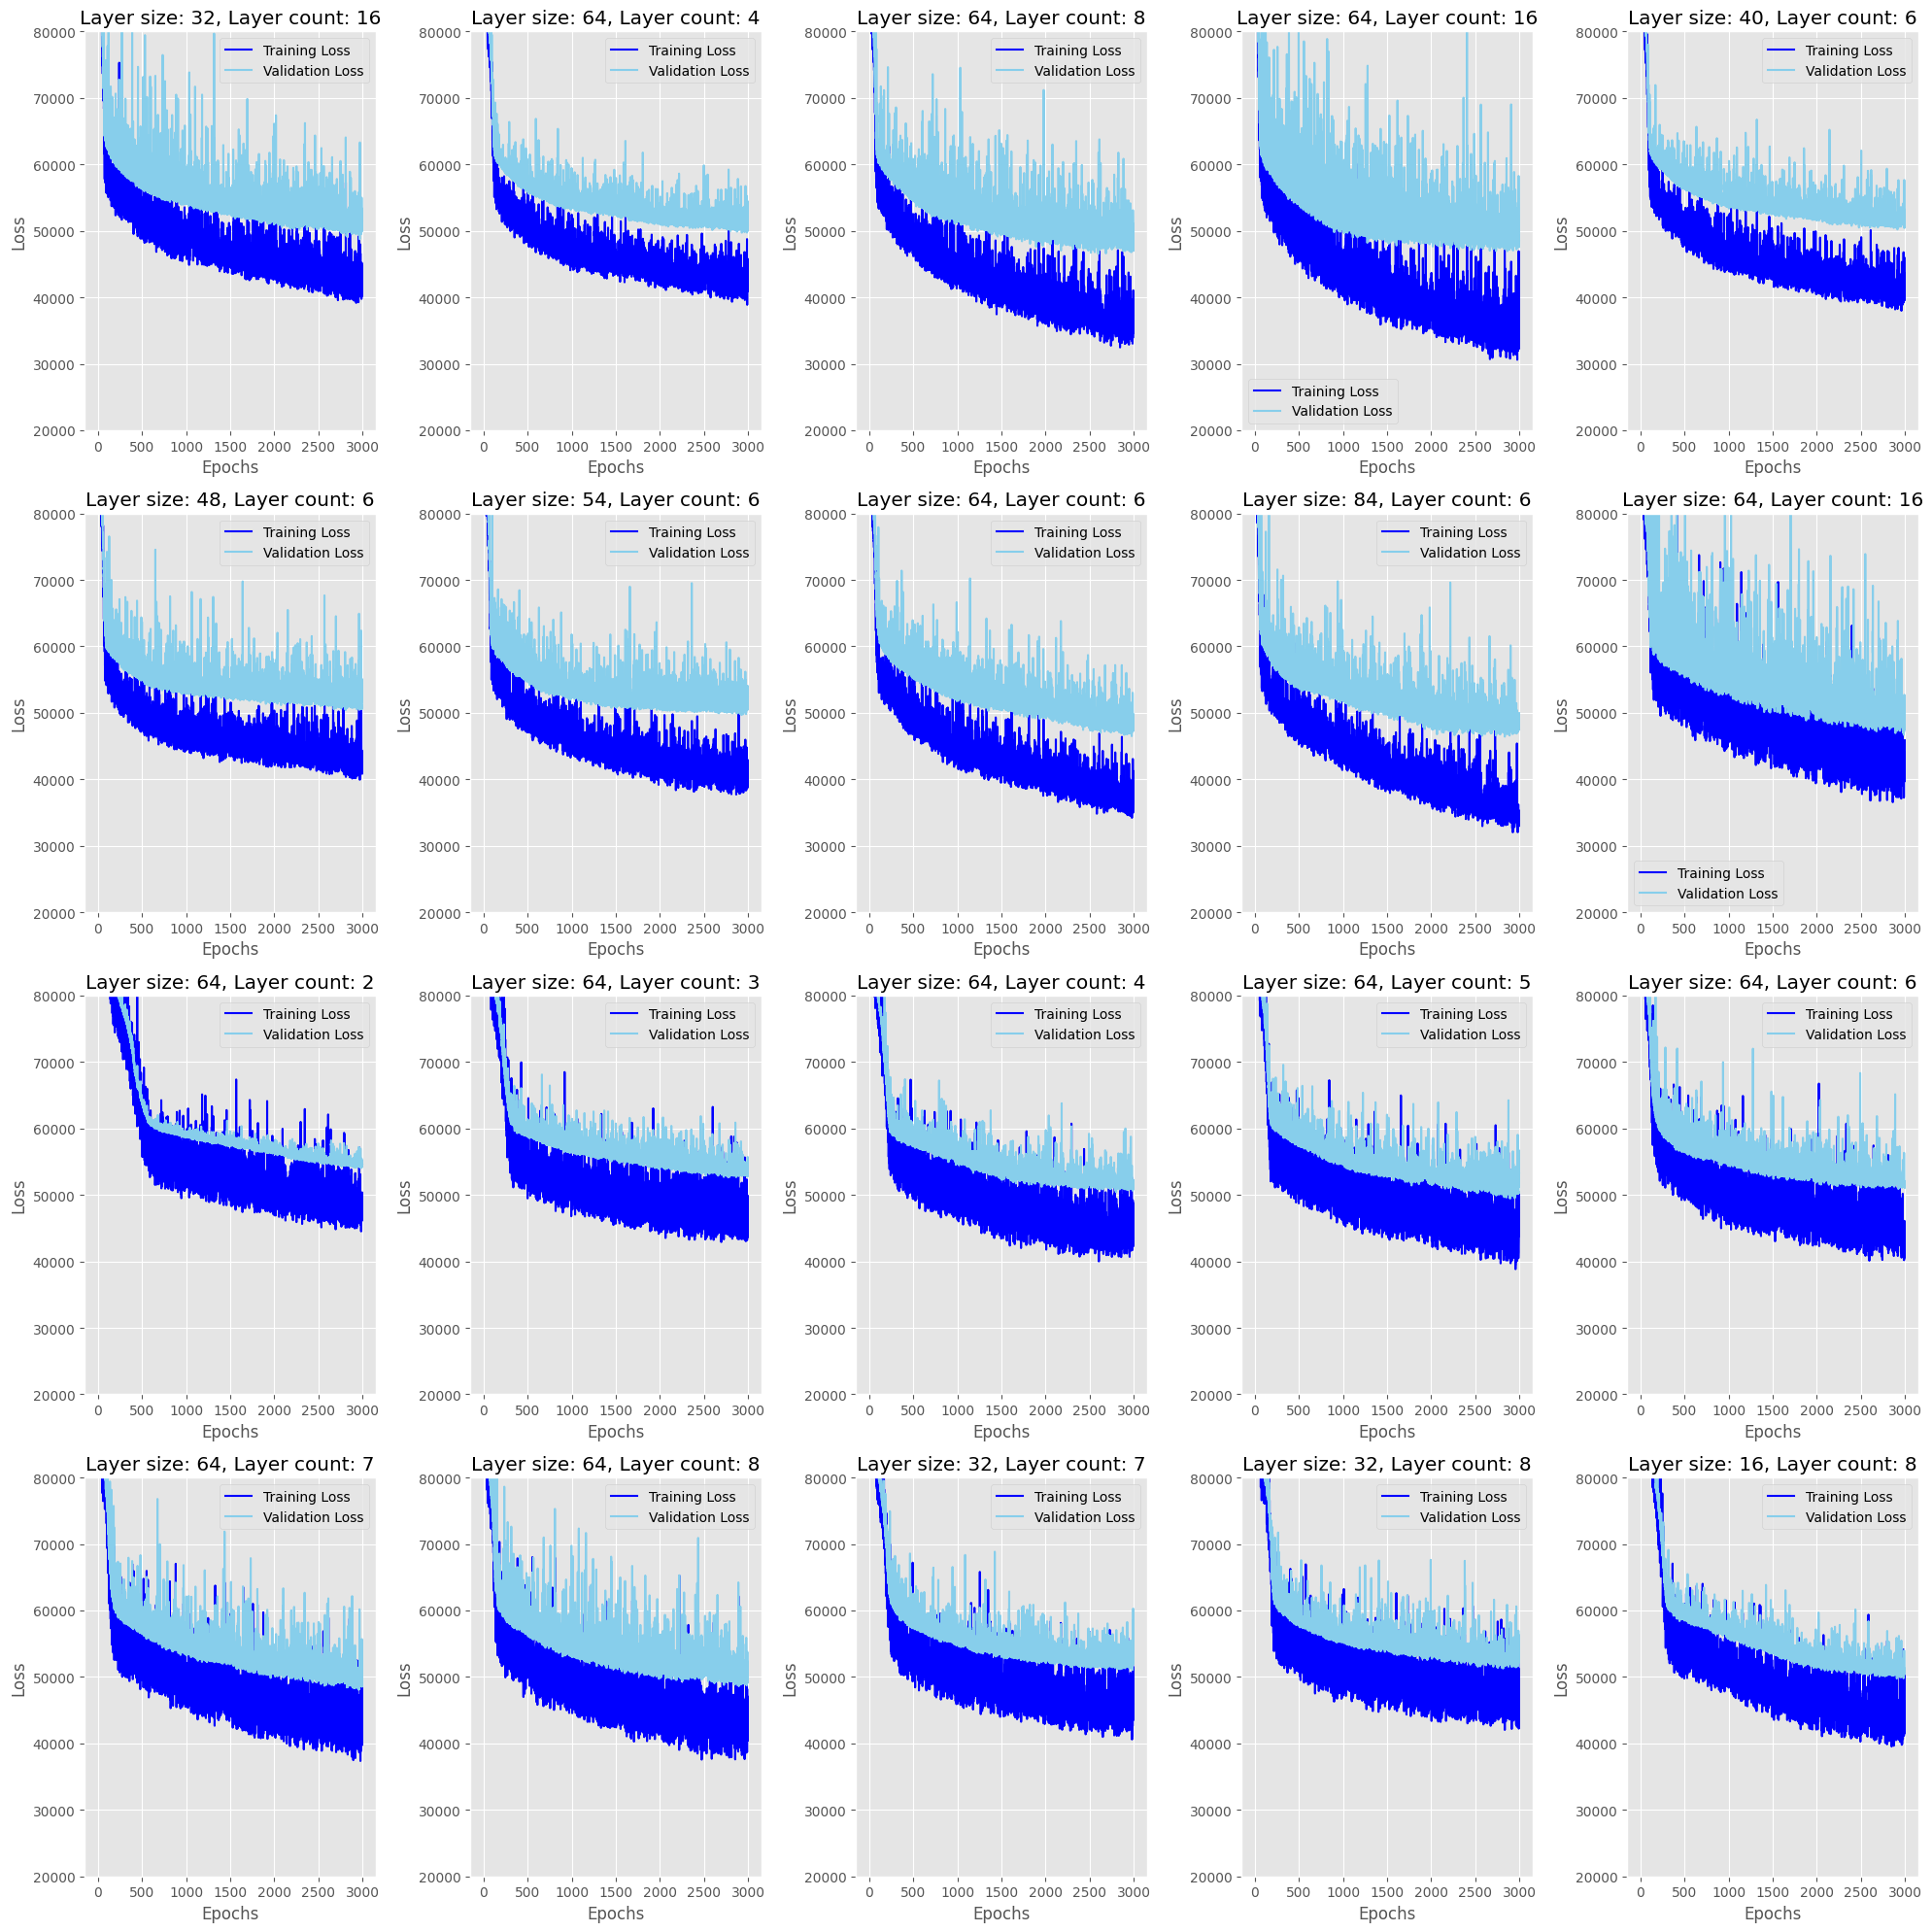

In [86]:
import matplotlib.pyplot as plt

# Assuming 'results' is your dictionary with training tuples as keys and (train_losses, val_losses) as values

# Define the size of the grid

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))  # Adjust the size as needed
plt.style.use('ggplot')
# Iterate over the results and create a subplot for each
for i, (params, (train_losses, val_losses)) in enumerate(results_all.items()):
    row = i // 5
    col = i % 5 
    
    ax = axs[row, col]
    
    ax.plot(train_losses, label='Training Loss', color = "b")
    ax.plot(val_losses, label='Validation Loss', color = "skyblue")
    ax.set_title(f'Layer size: {params[1]}, Layer count: {params[2]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ylim(20000, 80000)
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("../visualizations/DL_no_images_comparison.png", dpi=800)

# Show the plot
plt.show()
